<a href="https://colab.research.google.com/github/dolinger-nscc/datasets/blob/main/GPU_Test_Cirlces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

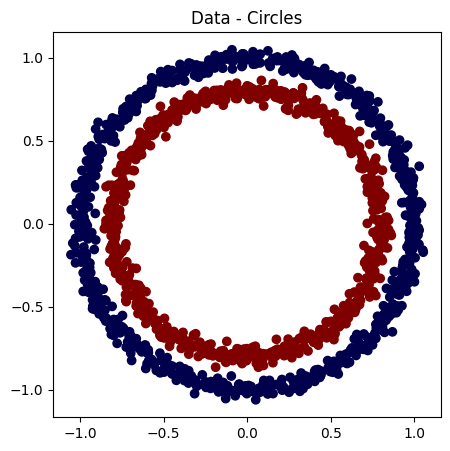

In [1]:
from sklearn.datasets import make_circles
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split


n_samples = 1500
seed = 28

x, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=seed)

plt.figure(figsize=(5,5))
plt.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.seismic)  
plt.title("Data - Circles")
plt.show()

In [2]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

# added for compare ...
# device = 'cpu'
# device

# Data to tensors
x = torch.from_numpy(x).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(x, 
                                                    y, 
                                                    test_size=0.2,
                                                    random_state=seed
)


from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=8)
        self.layer_2 = nn.Linear(in_features=8, out_features=4)
        self.layer_3 = nn.Linear(in_features=4, out_features=4)
        self.layer_4 = nn.Linear(in_features=4, out_features=1)
        self.relu = nn.ReLU() # <- ReLU as used in playground.tensorflow.org

    def forward(self, x):
        return self.layer_4(self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x))))))

model_3 = CircleModelV2().to(device)


# loss and optimizer 
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

# Classification accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [3]:
%%time

import warnings

with warnings.catch_warnings(record=True):

    # Fit the model
    torch.manual_seed(seed)
    epochs = 5000

    X_train, y_train = X_train.to(device), y_train.to(device)
    X_test, y_test = X_test.to(device), y_test.to(device)

    for epoch in range(epochs):
        # 1. forward
        y_logits = model_3(X_train).squeeze()
        y_pred = torch.round(torch.sigmoid(y_logits)) 

        # 2. loss and accuracy
        loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
        acc = accuracy_fn(y_true=y_train, 
                          y_pred=y_pred)

        # 3. zero grad
        optimizer.zero_grad()

        # 4. backward
        loss.backward()

        # 5. step
        optimizer.step()

        ### Test
        model_3.eval()
        with torch.inference_mode():
          # 1. forward
          test_logits = model_3(X_test).squeeze()
          test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
          # 2. loss and accuracy
          test_loss = loss_fn(test_logits, y_test)
          test_acc = accuracy_fn(y_true=y_test,
                                 y_pred=test_pred)


 #       if epoch % 100 == 0:
 #           print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")
    print(device)

cuda
CPU times: user 8.77 s, sys: 432 ms, total: 9.2 s
Wall time: 11.3 s


cuda


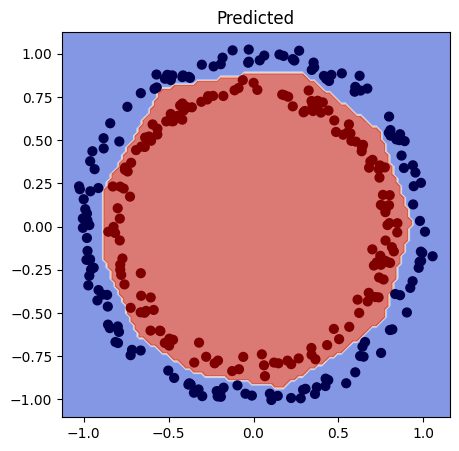

In [4]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.coolwarm, alpha=0.7)  #cmap=plt.cm.RdYlBu
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.seismic)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
# Predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y[:10] 

print(device)
plt.figure(figsize=(5, 5))
plt.title("Predicted")
plot_decision_boundary(model_3, X_test, y_test) 
plt.show()